### 1. Setting Up Environment and Loading Sign Language MNIST Dataset
This section provides a series of commands and code snippets to set up the required environment for working with the Sign Language MNIST dataset. It includes updating package lists, installing necessary packages such as Python 3 virtual environment, PyTorch, OpenCV, NumPy, ONNX, and ONNX Runtime, as well as downloading and extracting the Sign Language MNIST dataset. Additionally, it defines a class SignLanguageMNIST and functions to handle loading and preprocessing the dataset.

In [ ]:
# Update the package lists for packages that need upgrading
!apt-get update

# Upgrade all installed packages to their latest versions
!apt-get upgrade

# Install Python 3 virtual environment package
!apt-get install python3-venv

# Install PyTorch and torchvision using pip (Python package manager)
!python -m pip install torch torchvision

# Install OpenCV, NumPy, ONNX, and ONNX Runtime using pip
!python -m pip install opencv-python numpy onnx onnxruntime

# Install necessary libraries for handling image rendering
!apt-get install libsm6 libxext6 libxrender-dev

# Download the Sign Language MNIST dataset
!wget https://assets.digitalocean.com/articles/signlanguage_data/sign-language-mnist.tar.gz

# Extract the contents of the downloaded dataset archive
!tar -xzf sign-language-mnist.tar.gz

In [ ]:
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch

from typing import List

import csv


class SignLanguageMNIST(Dataset):
    """Sign Language classification dataset.

    Utility for loading Sign Language dataset into PyTorch. Dataset posted on
    Kaggle in 2017, by an unnamed author with username `tecperson`:
    https://www.kaggle.com/datamunge/sign-language-mnist

    Each sample is 1 x 1 x 28 x 28, and each label is a scalar.
    """

    @staticmethod
    def get_label_mapping():
        """
        Generate a mapping from dataset labels [0, 24] to letter indices [0, 25].
        Label 9 is excluded as it is not present in the dataset.
        """
        mapping = list(range(25))
        mapping.pop(9)
        return mapping

    @staticmethod
    def read_label_samples_from_csv(path: str):
        """
        Read labels and image samples from a CSV file.

        Args:
            path: Path to the CSV file containing label and pixel values.

        Returns:
            labels: List of labels.
            samples: List of image samples.
        """
        mapping = SignLanguageMNIST.get_label_mapping()
        labels, samples = [], []
        with open(path) as f:
            _ = next(f)  # skip header
            for line in csv.reader(f):
                label = int(line[0])
                labels.append(mapping.index(label))
                samples.append(list(map(int, line[1:])))
        return labels, samples

    def __init__(self,
                 path: str = "data/sign_mnist_train.csv",
                 mean: List[float] = [0.485],
                 std: List[float] = [0.229]):
        """
        Initialize the SignLanguageMNIST dataset.

        Args:
            path: Path to `.csv` file containing `label`, `pixel0`, `pixel1`...
            mean: Mean values for normalization.
            std: Standard deviation values for normalization.
        """
        labels, samples = SignLanguageMNIST.read_label_samples_from_csv(path)
        self._samples = np.array(samples, dtype=np.uint8).reshape((-1, 28, 28, 1))
        self._labels = np.array(labels, dtype=np.uint8).reshape((-1, 1))

        self._mean = mean
        self._std = std

    def __len__(self):
        """
        Get the length of the dataset.
        """
        return len(self._labels)

    def __getitem__(self, idx):
        """
        Get an item from the dataset by index.

        Args:
            idx: Index of the item to retrieve.

        Returns:
            Dictionary containing image and label tensors.
        """
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self._mean, std=self._std)])

        return {
            'image': transform(self._samples[idx]).float(),
            'label': torch.from_numpy(self._labels[idx]).float()
        }

In [ ]:
def get_train_test_loaders(batch_size=32):
    """
    Get training and testing data loaders for the Sign Language MNIST dataset.

    Args:
        batch_size (int): Batch size for the data loaders.

    Returns:
        trainloader (DataLoader): DataLoader for the training set.
        testloader (DataLoader): DataLoader for the testing set.
    """
    # Create DataLoader for the training set
    trainset = SignLanguageMNIST('data/sign_mnist_train.csv')
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for the testing set
    testset = SignLanguageMNIST('data/sign_mnist_test.csv')
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

if __name__ == '__main__':
    # Example usage: get data loader for training set and print the first batch
    loader, _ = get_train_test_loaders(2)
    print(next(iter(loader)))

{'image': tensor([[[[-0.0287,  0.0569,  0.1426,  ...,  0.3309,  0.3138,  0.2796],
          [ 0.0056,  0.1083,  0.1939,  ...,  0.3823,  0.3481,  0.3138],
          [ 0.0398,  0.1426,  0.2111,  ...,  0.4508,  0.3994,  0.3823],
          ...,
          [ 0.5536,  0.6563,  0.7591,  ...,  1.1529,  1.1358,  1.1187],
          [ 0.5878,  0.6906,  0.7762,  ...,  1.1700,  1.1529,  1.1187],
          [ 0.5707,  0.6734,  0.8104,  ...,  1.1872,  1.1700,  1.1358]]],


        [[[ 0.3138,  0.3481,  0.3481,  ...,  0.2967,  0.2624,  0.2453],
          [ 0.3481,  0.3823,  0.3823,  ...,  0.3138,  0.2967,  0.2624],
          [ 0.3823,  0.3994,  0.4166,  ...,  0.3309,  0.3138,  0.2967],
          ...,
          [ 0.8104,  0.9303,  0.6734,  ...,  0.9132,  0.7077, -0.3712],
          [ 0.8276,  0.8961,  0.8618,  ...,  0.9646,  0.0227, -0.6623],
          [ 0.8618,  0.8961,  0.9132,  ...,  0.0398, -0.6794, -0.8335]]]]), 'label': tensor([[20.],
        [23.]])}


### 2. Neural Network Training and Validation
This section includes the definition, training, and validation of a neural network model for a sign language recognition task. It covers the training process using PyTorch, validation using both PyTorch and ONNX, and includes utilities for model evaluation. Additionally, it provides a function to capture photos using a device camera in a Google Colab environment.

In [ ]:
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class Net(nn.Module):
    def __init__(self):
        """
        Initialize the neural network architecture.
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.conv3 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 48)
        self.fc3 = nn.Linear(48, 25)

    def forward(self, x):
        """
        Define the forward pass of the network.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def main():
    """
    Main function to train and save the neural network model.
    """
    net = Net().float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    trainloader, _ = get_train_test_loaders()
    for epoch in range(12):  # loop over the dataset multiple times
        train(net, criterion, optimizer, trainloader, epoch)
        scheduler.step()
    torch.save(net.state_dict(), "checkpoint.pth")

def train(net, criterion, optimizer, trainloader, epoch):
    """
    Training function for the neural network.

    Args:
        net: Neural network model.
        criterion: Loss criterion.
        optimizer: Optimizer.
        trainloader: DataLoader for training data.
        epoch: Current epoch number.
    """
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = Variable(data['image'].float())
        labels = Variable(data['label'].long())
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.6f' % (epoch, i, running_loss / (i + 1)))

if __name__ == '__main__':
    main()

[0,     0] loss: 3.219286
[0,   100] loss: 3.218236
[0,   200] loss: 3.209969
[0,   300] loss: 3.205206
[0,   400] loss: 3.200204
[0,   500] loss: 3.181691
[0,   600] loss: 3.090575
[0,   700] loss: 2.940123
[0,   800] loss: 2.756257
[1,     0] loss: 1.334102
[1,   100] loss: 1.004100
[1,   200] loss: 0.897542
[1,   300] loss: 0.825731
[1,   400] loss: 0.759176
[1,   500] loss: 0.703677
[1,   600] loss: 0.655215
[1,   700] loss: 0.613505
[1,   800] loss: 0.572767
[2,     0] loss: 0.125612
[2,   100] loss: 0.258468
[2,   200] loss: 0.257320
[2,   300] loss: 0.251559
[2,   400] loss: 0.245872
[2,   500] loss: 0.227223
[2,   600] loss: 0.217751
[2,   700] loss: 0.208239
[2,   800] loss: 0.199060
[3,     0] loss: 0.174102
[3,   100] loss: 0.121763
[3,   200] loss: 0.127207
[3,   300] loss: 0.131297
[3,   400] loss: 0.127363
[3,   500] loss: 0.120097
[3,   600] loss: 0.116395
[3,   700] loss: 0.112985
[3,   800] loss: 0.114371
[4,     0] loss: 0.010714
[4,   100] loss: 0.103812
[4,   200] l

In [ ]:
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np

import onnx
import onnxruntime as ort

def evaluate(outputs: Variable, labels: Variable) -> float:
    """
    Evaluate neural network outputs against non-one-hotted labels.

    Args:
        outputs (Variable): Predicted outputs from the neural network.
        labels (Variable): Actual labels.

    Returns:
        float: Evaluation accuracy.
    """
    Y = labels.numpy()
    Yhat = np.argmax(outputs, axis=1)
    return float(np.sum(Yhat == Y))

def batch_evaluate(
        net: Net,
        dataloader: torch.utils.data.DataLoader) -> float:
    """
    Evaluate neural network in batches, if dataset is too large.

    Args:
        net (Net): Neural network model.
        dataloader (torch.utils.data.DataLoader): DataLoader for evaluation.

    Returns:
        float: Evaluation accuracy.
    """
    score = n = 0.0
    for batch in dataloader:
        n += len(batch['image'])
        outputs = net(batch['image'])
        if isinstance(outputs, torch.Tensor):
            outputs = outputs.detach().numpy()
        score += evaluate(outputs, batch['label'][:, 0])
    return score / n

def validate():
    """
    Validate the trained model using PyTorch and ONNX.
    """
    trainloader, testloader = get_train_test_loaders()
    net = Net().float().eval()

    pretrained_model = torch.load("checkpoint.pth")
    net.load_state_dict(pretrained_model)

    print('=' * 10, 'PyTorch', '=' * 10)
    train_acc = batch_evaluate(net, trainloader) * 100.
    print('Training accuracy: %.1f' % train_acc)
    test_acc = batch_evaluate(net, testloader) * 100.
    print('Validation accuracy: %.1f' % test_acc)

    trainloader, testloader = get_train_test_loaders(1)

    # export to onnx
    fname = "signlanguage.onnx"
    dummy = torch.randn(1, 1, 28, 28)
    torch.onnx.export(net, dummy, fname, input_names=['input'])

    # check exported model
    model = onnx.load(fname)
    onnx.checker.check_model(model)  # check model is well-formed

    # create runnable session with exported model
    ort_session = ort.InferenceSession(fname)
    net = lambda inp: ort_session.run(None, {'input': inp.data.numpy()})[0]

    print('=' * 10, 'ONNX', '=' * 10)
    train_acc = batch_evaluate(net, trainloader) * 100.
    print('Training accuracy: %.1f' % train_acc)
    test_acc = batch_evaluate(net, testloader) * 100.
    print('Validation accuracy: %.1f' % test_acc)

if __name__ == '__main__':
    validate()

========== PyTorch ==========
Training accuracy: 99.8
Validation accuracy: 97.1
========== ONNX ==========
Training accuracy: 99.8
Validation accuracy: 96.8


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    """
    Take a photo using the device camera in a Google Colab environment.

    Args:
        filename (str): Name of the file to save the captured photo.
        quality (float): Quality of the captured photo.

    Returns:
        str: Filename of the saved photo.
    """
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

### 3. Sign Language Recognition with Webcam Capture

This script utilizes a webcam in a Google Colab environment to capture images and performs real-time sign language recognition using a pre-trained model.

The script employs OpenCV, ONNX Runtime, and Google Colab functionalities to capture images, preprocess them, and then recognize sign language gestures. The captured frames are center-cropped, converted to grayscale, resized, and normalized before being fed into a pre-trained model. The recognized sign is displayed on the captured frame for real-time feedback.

In [ ]:
import cv2
import numpy as np
import io
import onnxruntime as ort
from PIL import Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

def center_crop(frame):
    """
    Center crops the given frame to a square shape.

    Args:
        frame (numpy.ndarray): Input frame.

    Returns:
        numpy.ndarray: Center-cropped frame.
    """
    h, w, _ = frame.shape
    start = abs(h - w) // 2
    if h > w:
        return frame[start: start + w]
    return frame[:, start: start + h]

def take_photo(filename='photo.jpg', quality=0.8):
    """
    Takes a photo using the device camera in a Google Colab environment.

    Args:
        filename (str): Name of the file to save the captured photo.
        quality (float): Quality of the captured photo.

    Returns:
        str: Filename of the saved photo.
    """
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def main():
    """
    Main function to capture images and perform sign language recognition.

    Uses the device camera in a Google Colab environment to capture images,
    then performs sign language recognition using a pre-trained model.
    """
    # Constants
    index_to_letter = list('ABCDEFGHIKLMNOPQRSTUVWXY')
    mean = 0.485 * 255.
    std = 0.229 * 255.

    # Create runnable session with exported model
    ort_session = ort.InferenceSession("signlanguage.onnx")

    while True:
        # Take photo from webcam
        filename = take_photo()

        # Read the captured image
        frame = cv2.imread(filename)

        # Preprocess data
        frame = center_crop(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        x = cv2.resize(frame, (28, 28))
        x = (x - mean) / std

        x = x.reshape(1, 1, 28, 28).astype(np.float32)
        y = ort_session.run(None, {'input': x})[0]

        index = np.argmax(y, axis=1)
        letter = index_to_letter[int(index)]

        cv2.putText(frame, letter, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), thickness=2)
        cv2_imshow(frame)

        if cv2.waitKey(0) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

### 4. Auxiliary Recognition with Input Images (Optional)

Predicted letter: A


<ipython-input-30-063454029040>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  letter = index_to_letter[int(index)]


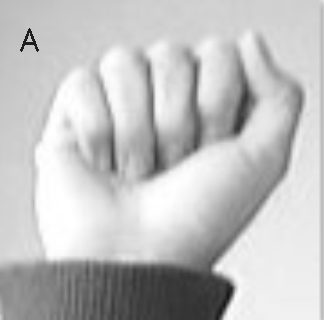

Predicted letter: B


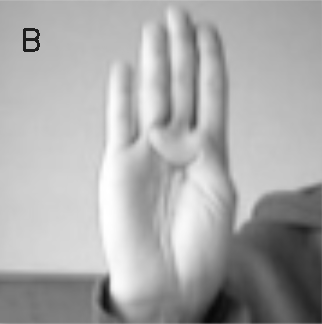

Predicted letter: C


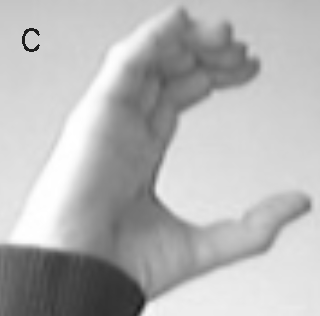

Predicted letter: E


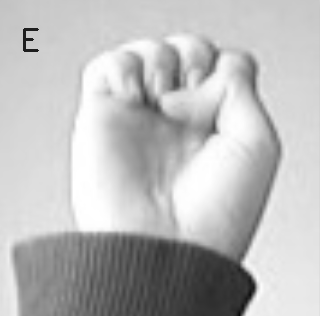

Predicted letter: L


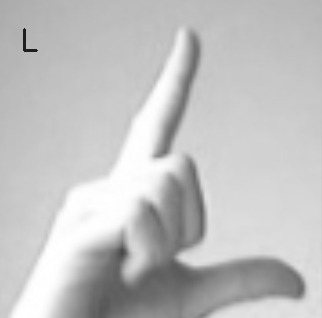

Predicted letter: N


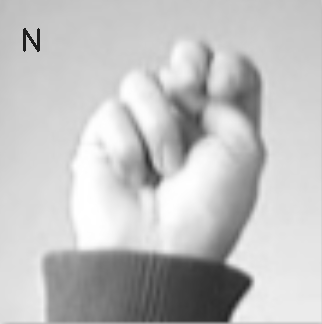

Predicted letter: O


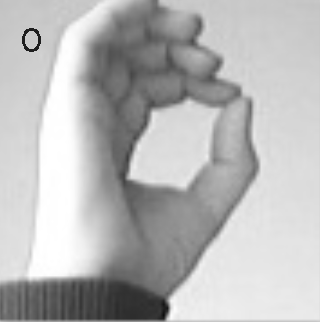

Predicted letter: U


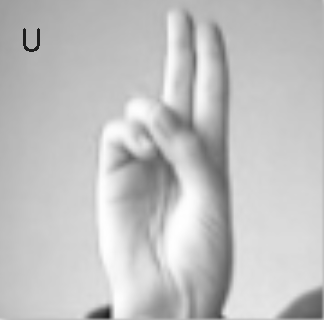

Predicted letter: R


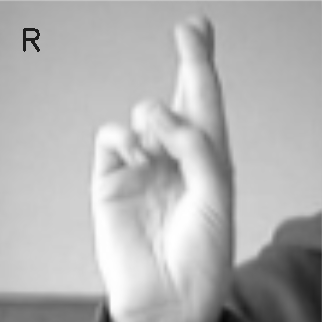

Predicted letter: S


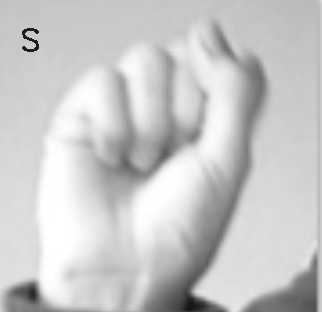

Predicted letter: U


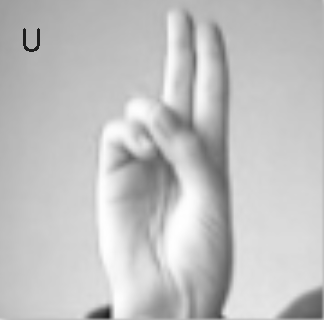

Predicted letter: T


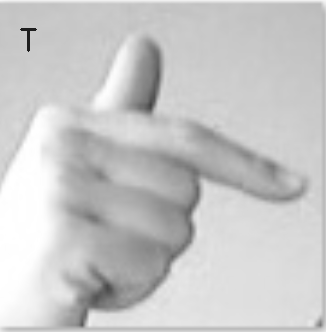

Predicted letter: G


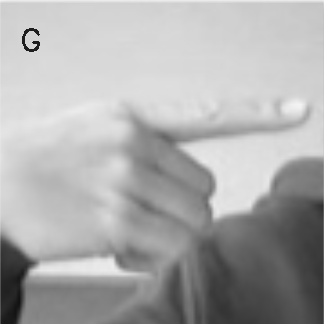

In [ ]:
import cv2
import numpy as np
import onnxruntime as ort

def center_crop(frame):
    """
    Center crops the given frame to a square shape.

    Args:
        frame (numpy.ndarray): Input frame.

    Returns:
        numpy.ndarray: Center-cropped frame.
    """
    h, w, _ = frame.shape
    start = abs(h - w) // 2
    if h > w:
        return frame[start: start + w]
    return frame[:, start: start + h]

def process_image(image_path):
    """
    Preprocesses the image for inference.

    Args:
        image_path (str): Path to the input image.

    Returns:
        numpy.ndarray: Processed image ready for inference.
    """
    # Read the image file
    frame = cv2.imread(image_path)

    # Preprocess data
    frame = center_crop(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (28, 28))

    return frame

def predict_letter(image_path, model_path="signlanguage.onnx"):
    """
    Predicts the letter in the given image.

    Args:
        image_path (str): Path to the input image.
        model_path (str): Path to the ONNX model file.

    Returns:
        tuple: Predicted letter and processed image.
    """
    # Constants
    index_to_letter = list('ABCDEFGHIKLMNOPQRSTUVWXY')
    mean = 0.485 * 255.
    std = 0.229 * 255.

    # Create runnable session with exported model
    ort_session = ort.InferenceSession(model_path)

    # Process the image
    processed_image = process_image(image_path)
    processed_image = (processed_image - mean) / std
    processed_image = processed_image.reshape(1, 1, 28, 28).astype(np.float32)

    # Run inference
    y = ort_session.run(None, {'input': processed_image})[0]

    # Get predicted letter
    index = np.argmax(y, axis=1)
    letter = index_to_letter[int(index)]

    return letter, processed_image

def draw_predicted_letter(image_path, predicted_letter):
    """
    Draws the predicted letter on the image and displays it.

    Args:
        image_path (str): Path to the input image.
        predicted_letter (str): Predicted letter.
    """
    # Load the original image
    img = cv2.imread(image_path)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Draw predicted letter on the grayscale image
    cv2.putText(gray, predicted_letter, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (30, 30, 30), thickness=2)

    # Display the image
    cv2.imshow('Predicted Letter', gray)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
if __name__ == '__main__':
    file_paths = ['a.png', 'b.png', 'c.png', 'e.png', 'l.png', 'n.png', 'o.png', 'u.png', 'r.png', 's.png', 'u.png', 't.png', 'g.png']
    for path in file_paths:
        predicted_letter, processed_image = predict_letter(path)
        print("Predicted letter:", predicted_letter)
        draw_predicted_letter(path, predicted_letter)